In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys

In [14]:
# results2 = pd.read_csv("../test_results/hyper_sdqlpy_optimisations_v2_pandas_tpch_test_results.csv") 
# #results2 = results2.rename(columns={"Average": "Mean"})

# results2 = results2[results2["Query Name"].isin(["SDQLpy Converted + PipelineBreakers NRP (Hyper DB)", "SDQLpy Converted + Both NRP (Hyper DB)"])]

In [3]:
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_opt_o4_comparison_test_results.csv") 

#results = pd.concat([results, results2], ignore_index=True)
#results = results.rename(columns={"Average": "Mean"})

In [4]:
print(len(results))
results.head()

154


,Data Type,Scaling Factor,Query Name,Query Number,Average,Correct,Executed,Runs
0,SQL,1,Hyper DB,Query 1,0.2990,True,Yes,"[0.28839564323425293, 0.2917461395263672, 0.31..."
1,SDQLpy,1,SDQLpy Converted (Hyper DB),Query 1,1.4700,True,Yes,"[1.4763152599334717, 1.5563132762908936, 1.447..."
2,SDQLpy,1,SDQLpy Converted + O4 (Hyper DB),Query 1,1.3500,True,Yes,"[1.3387641906738281, 1.3538529872894287, 1.341..."
3,SDQLpy,1,"SDQLpy Converted + O1,O2 (Hyper DB)",Query 1,0.0938,True,Yes,"[0.09838581085205078, 0.09351801872253418, 0.0..."
4,SDQLpy,1,"SDQLpy Converted + O1,O2,O4 (Hyper DB)",Query 1,0.0872,True,Yes,"[0.09086894989013672, 0.08392190933227539, 0.0..."


In [5]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

154


In [6]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_gmean(runs):
    return g_mean(runs[1:])

results["Mean"] = results.apply(lambda row : ignore_first_gmean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]
results = results[["Query Type", "Query Number", "Mean", "Runs"]]

In [7]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [19]:
def make_compare_graph(title, df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='center right', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)
    
    # ax.set_title(title)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()
    
def make_average_graph(df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    plt.xticks(rotation=45, ha='right')
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [9]:
scale_amount = 1.35

class DBColors(Enum):
    # POSTGRES = "#edae49"
    # PD_POSTGRES = scale_lightness("#edae49", scale_amount)
    # HYPER = "#d1495b"
    # PD_HYPER = scale_lightness("#d1495b", 1.25)
    # SDQL_HYPER = scale_lightness("#d1495b", 1.50)
    # DUCK = "#00798c"
    # PD_DUCK = scale_lightness(handle_colour('tab:green'), scale_amount)
    HYPER = "#FC9F5B"
    SDQLPY = "#FBD1A2"
    SDQLPY_HESAM = "#D80032"
    SDQLPY_VF = "#ECE4B7"
    SDQLPY_PB = "#B5DAB7"
    SDQLPY_PB_NRP = "#00798c"  # NRP - No Right (Filter) Propagation
    SDQLPY_BOTH = "#7DCFB6"
    SDQLPY_BOTH_NRP = "#d1495b"  # NRP - No Right (Filter) Propagation
    PANDAS = "#33CA7F"
    

## Hesam Comparison

The DataFrame has 66 rows


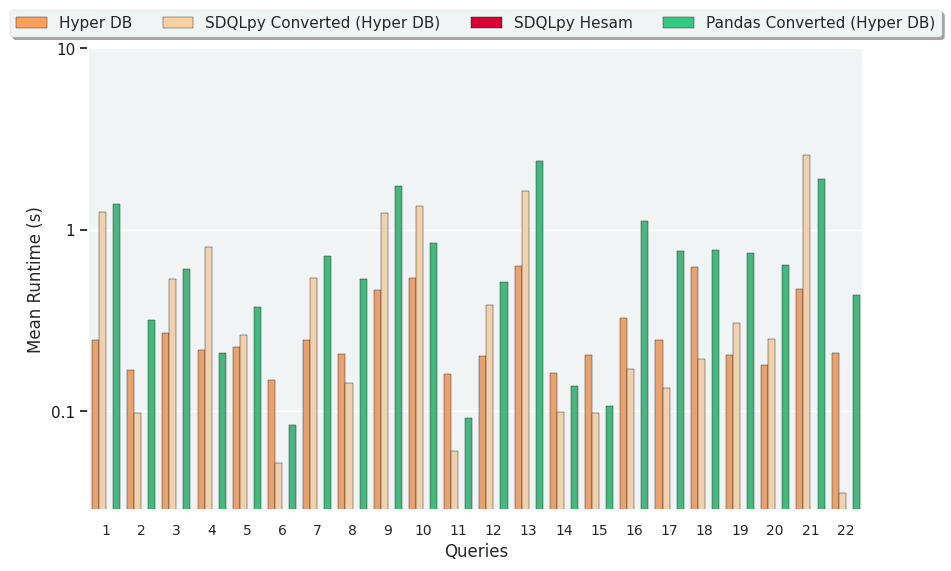

In [22]:
all_4_order = ["Hyper DB", "SDQLpy Converted (Hyper DB)", "SDQLpy Hesam",
               "Pandas Converted (Hyper DB)"]
all_4_data = results[results["Query Type"].isin(all_4_order)]

all_4_color = [DBColors.HYPER.value, DBColors.SDQLPY.value, DBColors.SDQLPY_HESAM.value, DBColors.PANDAS.value]
all_4_hatch = [None, None, None, None]
all_4_filename = None

make_compare_graph(all_4_data, 
                   all_4_order,
                   all_4_color,
                   all_4_hatch,
                   all_4_filename)

## Hesam Chart (25/01/2024)

- A chart that compares Pandas, Naive, Optimized, and Hyper for all supported queries. By optimized version, I only mean the fusion optimizer

In [50]:
results

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.345134,"[0.28395891189575195, 0.2900824546813965, 0.25..."
1,SDQLpy Converted (Hyper DB),1,1.640931,"[1.6518559455871582, 1.6394803524017334, 1.648..."
2,SDQLpy Converted + PB_VF (Hyper DB),1,0.025215,"[0.028687238693237305, 0.025115489959716797, 0..."
3,SDQLpy Converted + All (Hyper DB),1,0.025200,"[0.027543306350708008, 0.025005102157592773, 0..."
4,Pandas Converted (Hyper DB),1,1.745557,"[1.5831563472747803, 1.8525631427764893, 1.874..."
...,...,...,...,...
108,SDQLpy Converted + All (Hyper DB),22,0.090733,"[0.09768366813659668, 0.08133530616760254, 0.0..."
105,Hyper DB,22,0.215063,"[0.204118013381958, 0.20078492164611816, 0.180..."
106,SDQLpy Converted (Hyper DB),22,0.040712,"[0.05298185348510742, 0.043473243713378906, 0...."
107,SDQLpy Converted + PB_VF (Hyper DB),22,0.030050,"[0.05142092704772949, 0.03028702735900879, 0.0..."


In [51]:
results['Query Type'] = results['Query Type'].replace(
    {
        'SDQLpy Converted (Hyper DB)': 'Naive SDQLpy',
        'SDQLpy Converted + PB_VF (Hyper DB)': 'O1 SDQLpy',
        'SDQLpy Converted + All (Hyper DB)': 'O1+O2 SDQLpy',
        'Pandas Converted (Hyper DB)': 'Pandas'
     }
)

In [52]:
results

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.345134,"[0.28395891189575195, 0.2900824546813965, 0.25..."
1,Naive SDQLpy,1,1.640931,"[1.6518559455871582, 1.6394803524017334, 1.648..."
2,O1 SDQLpy,1,0.025215,"[0.028687238693237305, 0.025115489959716797, 0..."
3,O1+O2 SDQLpy,1,0.025200,"[0.027543306350708008, 0.025005102157592773, 0..."
4,Pandas,1,1.745557,"[1.5831563472747803, 1.8525631427764893, 1.874..."
...,...,...,...,...
108,O1+O2 SDQLpy,22,0.090733,"[0.09768366813659668, 0.08133530616760254, 0.0..."
105,Hyper DB,22,0.215063,"[0.204118013381958, 0.20078492164611816, 0.180..."
106,Naive SDQLpy,22,0.040712,"[0.05298185348510742, 0.043473243713378906, 0...."
107,O1 SDQLpy,22,0.030050,"[0.05142092704772949, 0.03028702735900879, 0.0..."


The DataFrame has 110 rows


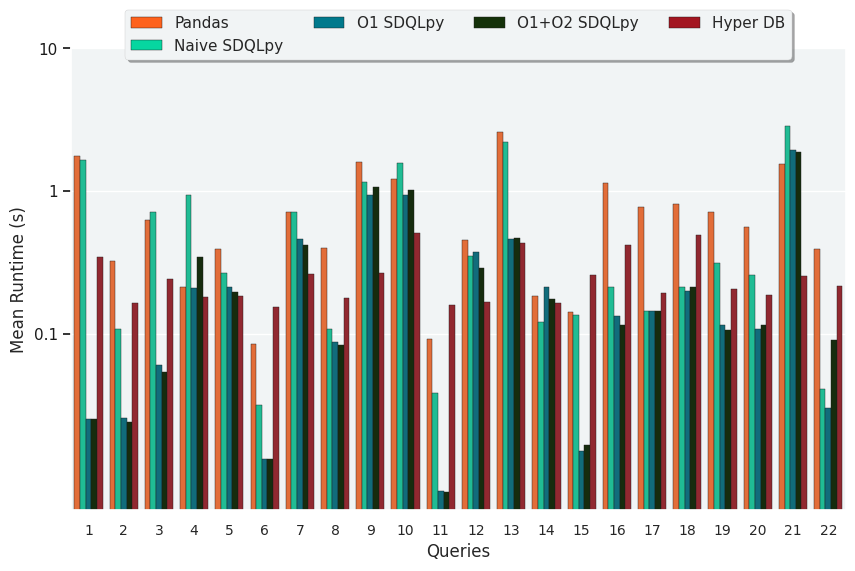

In [53]:
# All 4 Datapoints - TPC-H
class HesamColours(Enum):
    HYPER = "#A31621"
    NAIVE_SDQLPY = "#06D6A0"
    OPT_SDQLPY = "#143109"
    PANDAS = "#FE621D"

all_4_order = ["Pandas", "Naive SDQLpy", "O1 SDQLpy", "O1+O2 SDQLpy", "Hyper DB"]
all_4_data = results[results["Query Type"].isin(all_4_order)]

all_4_color = [HesamColours.PANDAS.value, HesamColours.NAIVE_SDQLPY.value,
               DBColors.SDQLPY_PB_NRP.value, HesamColours.OPT_SDQLPY.value, HesamColours.HYPER.value]
all_4_hatch = [None, None, None, None, None]
all_4_filename = "../analysis_results/FourThreads_Hyper_SDQLpy_Optimised_27012024.jpg"
all_4_title = "TPC-H Single Threaded"

make_compare_graph(all_4_title,
                   all_4_data, 
                   all_4_order,
                   all_4_color,
                   all_4_hatch,
                   all_4_filename)

In [27]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", "mean")
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(10)

,Overall Mean Runtime (s)
Query Type,
Hyper DB,0.288683
O1+O2 SDQLpy,0.313563
O1 SDQLpy,0.320117
Naive SDQLpy,0.556358
Pandas,0.746462


## Graphs to Produce

- All 6 Datapoints - TPC-H
- Hyper VS Pandas (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
- SDQLpy Converted (Hyper) VS SDQLpy Converted + VerticalFolding (Hyper) VS SDQLpy Converted + PipelineBreakers (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H

['#FC9F5B', '#FBD1A2', '#ECE4B7', '#B5DAB7', '#7DCFB6', '#33CA7F']
The DataFrame has 22 rows


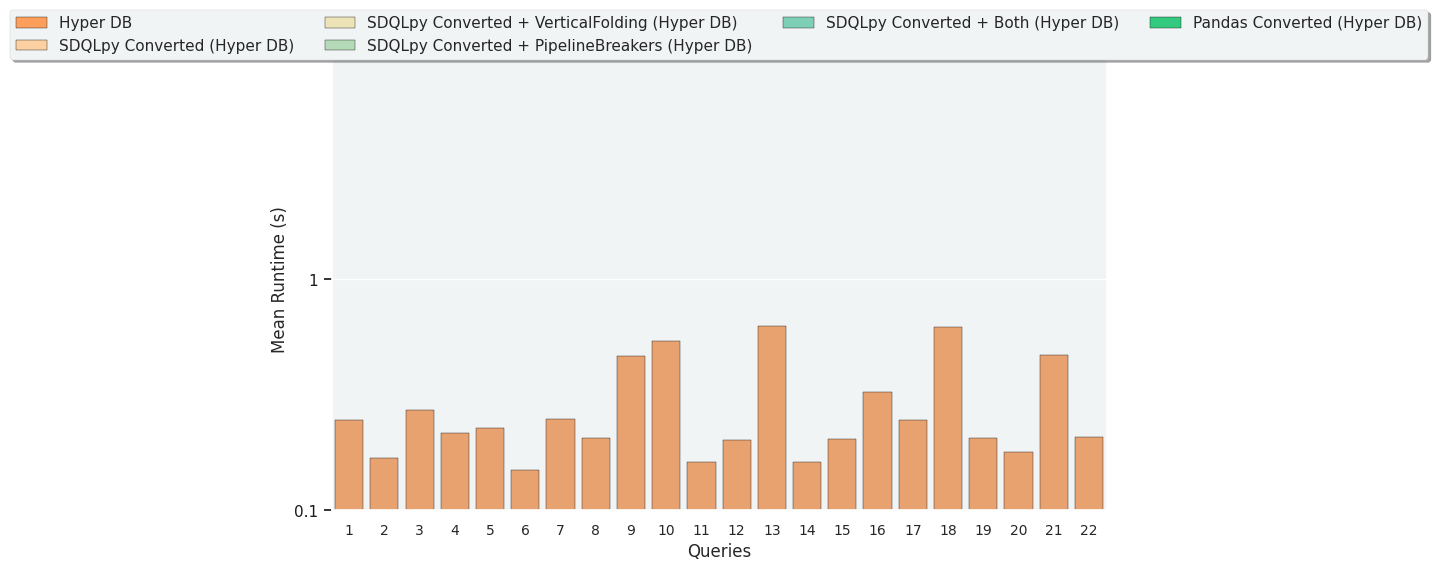

In [28]:
# All 6 Datapoints - TPC-H
all_6_order = ["Hyper DB", "SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
               "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + Both (Hyper DB)",
               "Pandas Converted (Hyper DB)"]
all_6_data = results[results["Query Type"].isin(all_6_order)]

all_6_color = [DBColors.HYPER.value, DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
               DBColors.SDQLPY_PB.value, DBColors.SDQLPY_BOTH.value, DBColors.PANDAS.value]
print(all_6_color)
all_6_hatch = [None, None, None, None, None, None]
all_6_filename = None

make_compare_graph(all_6_data, 
                   all_6_order,
                   all_6_color,
                   all_6_hatch,
                   all_6_filename)

The DataFrame has 22 rows


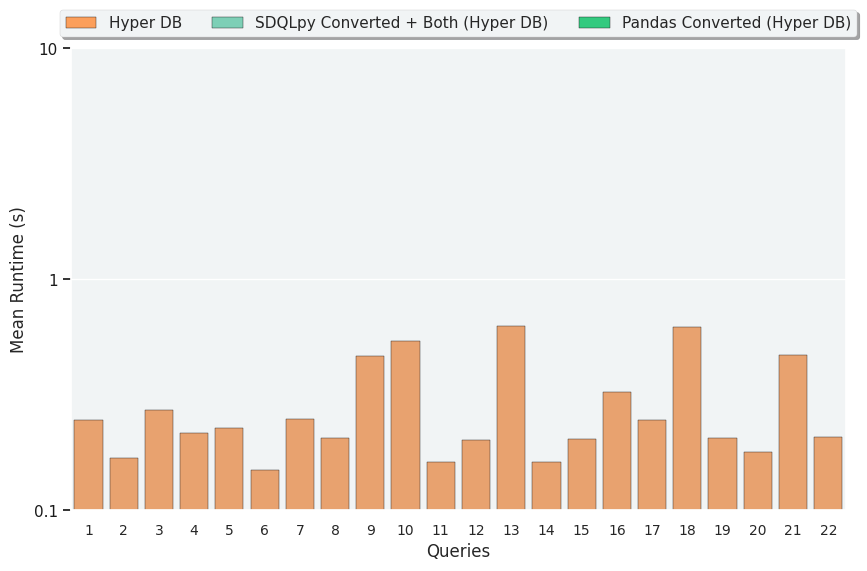

In [29]:
#  Hyper VS Pandas (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
hyper_vs_pd_vs_sdqlpy_best_order = ["Hyper DB", "SDQLpy Converted + Both (Hyper DB)",
               "Pandas Converted (Hyper DB)"]
hyper_vs_pd_vs_sdqlpy_best_data = results[results["Query Type"].isin(hyper_vs_pd_vs_sdqlpy_best_order)]

hyper_vs_pd_vs_sdqlpy_best_color = [DBColors.HYPER.value, DBColors.SDQLPY_BOTH.value, DBColors.PANDAS.value]
hyper_vs_pd_vs_sdqlpy_best_hatch = [None, None, None]
hyper_vs_pd_vs_sdqlpy_best_filename = None

make_compare_graph(hyper_vs_pd_vs_sdqlpy_best_data, 
                   hyper_vs_pd_vs_sdqlpy_best_order,
                   hyper_vs_pd_vs_sdqlpy_best_color,
                   hyper_vs_pd_vs_sdqlpy_best_hatch,
                   hyper_vs_pd_vs_sdqlpy_best_filename)

The DataFrame has 0 rows


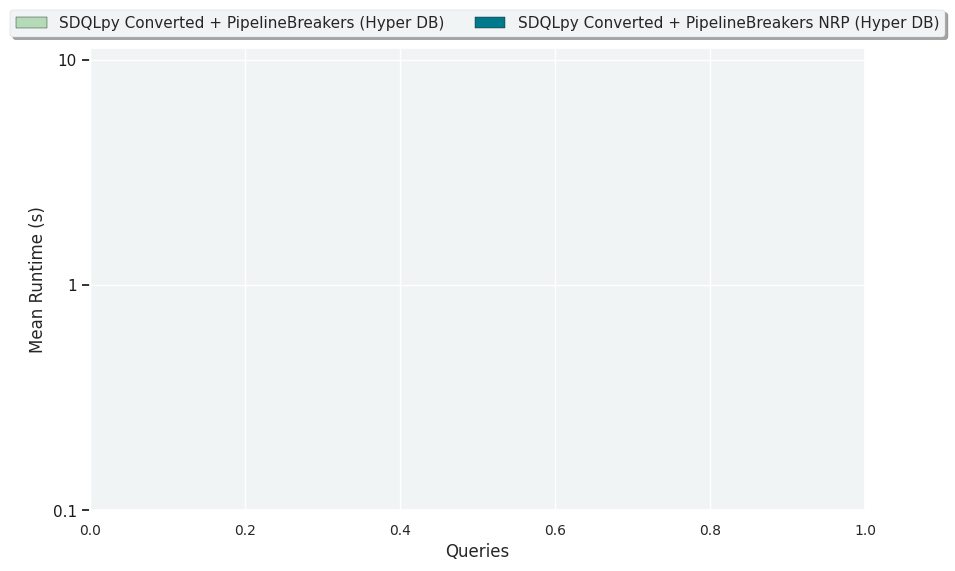

In [30]:
# SDQLpy Converted (Hyper) VS SDQLpy Converted + VerticalFolding (Hyper) VS SDQLpy Converted + PipelineBreakers (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
sdqlpy_versions_order = [#"SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
                                    "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + PipelineBreakers NRP (Hyper DB)"] # ,
                                    #"SDQLpy Converted + Both (Hyper DB)", "SDQLpy Converted + Both V2 (Hyper DB)"]
sdqlpy_versions_data = results[results["Query Type"].isin(sdqlpy_versions_order)]

sdqlpy_versions_color = [#DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
                         DBColors.SDQLPY_PB.value, DBColors.SDQLPY_PB_NRP.value] # ,
                         #DBColors.SDQLPY_BOTH.value, DBColors.SDQLPY_BOTH_V2.value]
sdqlpy_versions_hatch = [None, None] #, None, None, None, None]
sdqlpy_versions_filename = None

make_compare_graph(sdqlpy_versions_data, 
                   sdqlpy_versions_order,
                   sdqlpy_versions_color,
                   sdqlpy_versions_hatch,
                   sdqlpy_versions_filename)

# NRP - No Right Filter Propagation
# We are carrying a filter from the right side up into the join
# This is instead of creating another summation, *can* we use some heuristics to determine whether it's worth doing
# As sometimes, moving it is quicker (Q3) - but sometimes, leaving it is quicker (Q19)

# Doing Right Filter Propagation is:
# Equivalent: Q1, Q2, Q4, Q5, Q6, Q8, Q9, Q10, Q11, Q15, Q16, Q18, Q20
# Quicker: Q3, 
# Slower: Q12, Q14, Q19

## Statistics

In [17]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", "mean")
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(10)

,Overall Mean Runtime (s)
Query Type,
O1+O2+O4 SDQLpy,0.260713
Hyper DB,0.279434
O1+O2 SDQLpy,0.303240
O4 SDQLpy,0.439060
Naive SDQLpy,0.567511
O4 Pandas,0.633025
Naive Pandas,0.645916


The DataFrame has 7 rows


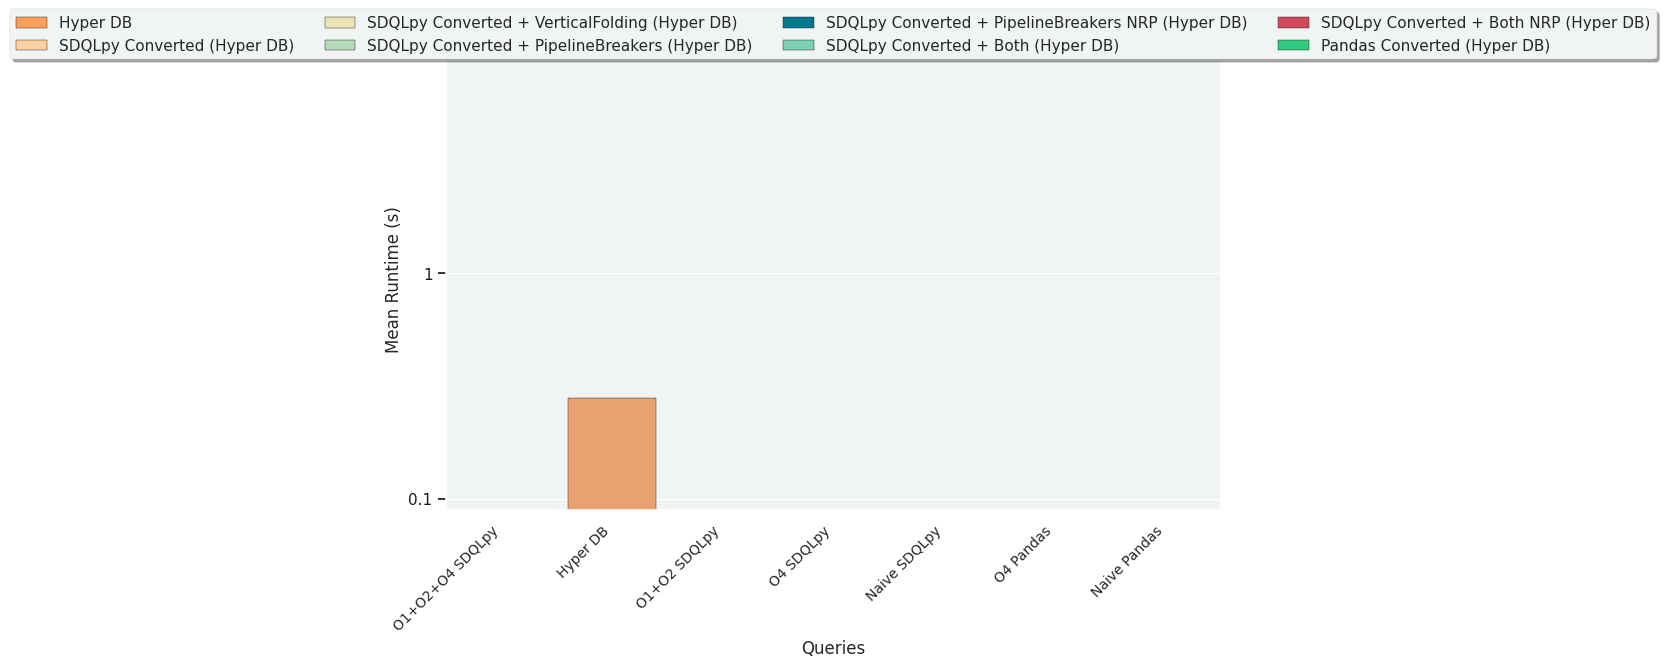

In [18]:
# Average runtime chart

# Hyper VS Pandas (Hyper) - TPC-H
hyper_order = ["Hyper DB", "SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
               "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + PipelineBreakers NRP (Hyper DB)", "SDQLpy Converted + Both (Hyper DB)",
               "SDQLpy Converted + Both NRP (Hyper DB)", "Pandas Converted (Hyper DB)"]
hyper_color = [DBColors.HYPER.value, DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
               DBColors.SDQLPY_PB.value, DBColors.SDQLPY_PB_NRP.value,  DBColors.SDQLPY_BOTH.value,
               DBColors.SDQLPY_BOTH_NRP.value,  DBColors.PANDAS.value]
hyper_hatch = [None, None, None, None, None, None, None, None]
hyper_filename = None

make_average_graph(overall, 
                   hyper_order,
                   hyper_color,
                   hyper_hatch,
                   hyper_filename, "Query Type", "Overall Mean Runtime (s)")